### TP 3

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [47]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

#### FILTRADO ESPECTRAL

In [48]:
def create_gauss_filter(h,w,k_size,sigma):
    # creo un filtro gaussiano
    gauss_kernel = cv.getGaussianKernel(k_size, sigma)
    # aplicar filtro 
    gauss_filter = np.outer(gauss_kernel, gauss_kernel)
    # fourier trasnform
    gauss_filter_fft = np.fft.fft2(gauss_filter)
    return gauss_filter, gauss_filter_fft


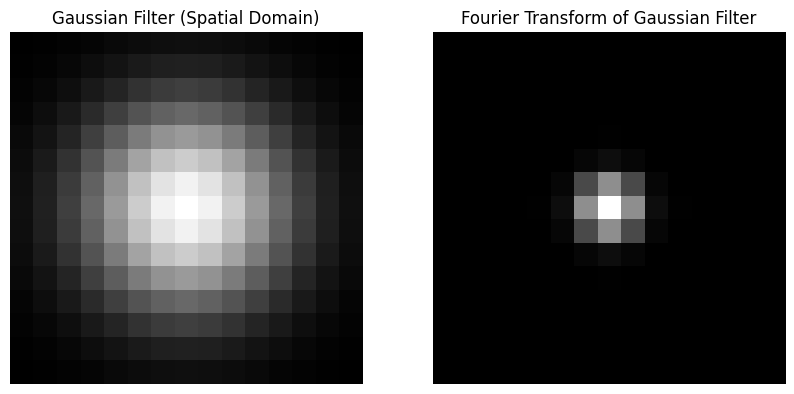

In [77]:
h, w = 100, 100
k_size = 15
sigma = 3

gauss_filter, gauss_filter_fft = create_gauss_filter(h, w, k_size, sigma)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gauss_filter, cmap='gray')
plt.title('Gaussian Filter (Spatial Domain)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(gauss_filter_fft))), cmap='gray')
plt.title('Fourier Transform of Gaussian Filter')
plt.axis('off')

plt.show()

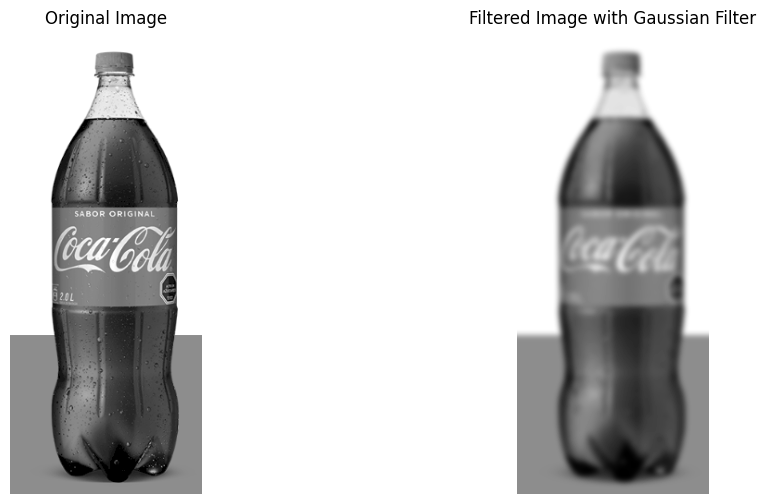

In [81]:
cc_image = cv.imread('./TP3/images/coca_logo_1.png', cv.IMREAD_GRAYSCALE)

h, w = image.shape
k_size = 15
sigma = 3

gauss_filter, _ = create_gauss_filter(h, w, k_size, sigma)

freq_filtered_image = cv.filter2D(cc_image, -1, gauss_filter)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cc_filtered_image, cmap='gray')
plt.title('Filtered Image with Gaussian Filter')
plt.axis('off')

plt.show()

#### FILTRADO CONVOLUCIONAL

In [82]:
def conv_gaussian_filter(image, kernel_size, sigma):
    """
    Applies Gaussian filter to the input image using convolution.
    
    Args:
        image (numpy.ndarray): Input image.
        kernel_size (int): Size of the filter kernel (should be odd).
        sigma (float): Standard deviation of the Gaussian distribution.
        
    Returns:
        numpy.ndarray: Filtered image.
    """
    # Create Gaussian kernel
    kernel = cv.getGaussianKernel(kernel_size, sigma)
    gaussian_kernel = np.outer(kernel, kernel)
    
    # Ensure image and kernel have the same number of channels
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    if len(gaussian_kernel.shape) == 2:
        gaussian_kernel = np.expand_dims(gaussian_kernel, axis=-1)
    
    # Ensure kernel is square
    k_size = gaussian_kernel.shape[0]
    if k_size % 2 == 0:
        raise ValueError("Kernel size should be odd.")
    
    # Apply filter to each channel of the image
    filtered_image = np.zeros_like(image)
    for c in range(image.shape[2]):
        filtered_image[:, :, c] = cv.filter2D(image[:, :, c], -1, gaussian_kernel)
    
    return filtered_image



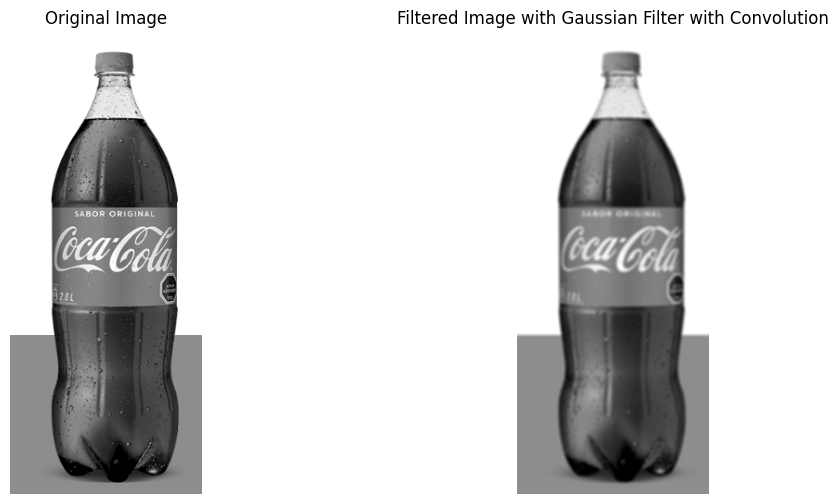

In [83]:

# Define kernel size and sigma for Gaussian filter
kernel_size = 5
sigma = 1.5

conv_filtered_image = conv_gaussian_filter(cc_image, kernel_size, sigma)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cc_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(conv_filtered_image, cmap='gray')
plt.title('Filtered Image with Gaussian Filter with Convolution')
plt.axis('off')

plt.show()



#### MEDICIÓN DE BLURRINESS DE LAS IMAGENES PROPUESTA EN EL PAPER

## Algorithm for Image Quality Measure (FM)

This algorithm calculates the image quality measure (FM) of an image using the frequency domain. Higher FM values indicate better image quality (less blur).

**Input:**

* Image I of size M×N (numpy array)

**Output:**

* Image quality measure (FM)

**Steps:**

1. **Compute Fourier Transform (F):**
   - Calculate the Fast Fourier Transform (FFT) of the image I.

2. **Find Centered Fourier Transform (Fc):**
   - Shift the origin of F to the center using `fftshift`. This puts the low-frequency components in the center.

3. **Absolute Value (AF):**
   - Calculate the absolute value of the centered Fourier transform (Fc).

4. **Maximum Frequency Component (M):**
   - Find the maximum value in the absolute value array (AF).

5. **Threshold (thres):**
   - Set a threshold value (thres) as a proportion of the maximum value (M) - typically M/1000.

6. **Count High-Frequency Pixels (TH):**
   - Count the number of pixels in AF that are greater than the threshold (thres). These pixels correspond to high-frequency components in the image, which are less affected by blur.

7. **Image Quality Measure (FM):**
   - Calculate the FM using the following equation:
FM = T/(M*N)


In [84]:
from scipy.fft import fft2, fftshift

def freq_focus_measure(img):
    f = fft2(img)
    fc = fftshift(f)
    af = np.abs(fc)
    m = np.max(af)
    thres = m/1000
    th = np.sum(af > thres)
    fm = th / (img.shape[0] * img.shape[1])
    return fm

In [85]:
print('Quality measure original image:', freq_focus_measure(cc_image))
print('Quality measure filtered image using frequency focus measure:', freq_focus_measure(freq_filtered_image))
print('Quality measure filtered image using frequency focus measure:', freq_focus_measure(conv_filtered_image))


Quality measure original image: 0.04068599033816425
Quality measure filtered image using frequency focus measure: 0.012859903381642512
Quality measure filtered image using frequency focus measure: 0.32467632850241546


#### Modified laplacian 

$$ \phi(x,y)=\sum_{(i,j)\in\Omega(x,y)}\Delta_{m}I(i,j) $$


In [88]:
def modified_laplacian_cv(image, window_size):
  """
  Args:
      image: A grayscale OpenCV image.
      window_size: The size of the neighborhood around each pixel.

  Returns:
      A 2D numpy array containing the modified Laplacian focus measure for each pixel.
  """

  # Convierto a float 32
  image = image.astype(np.float32)

  # kernel para el modified laplacian
  kernel_x = np.array([[-1, 1], [0, 0]])
  kernel_y = np.array([[0, 0], [-1, 1]])

  # Calculo modified Laplacian en x e y 
  laplacian_x = cv.filter2D(image, cv.CV_32F, kernel_x)
  laplacian_y = cv.filter2D(image, cv.CV_32F, kernel_y)

  # calculo la diff absoluta y la suma para el modified laplacian
  modified_laplacian = np.abs(laplacian_x) + np.abs(laplacian_y)

  # box filter para suma de vecinos (ajusto kernel size para window size 
  focus_measure = cv.filter2D(modified_laplacian, cv.CV_32F, np.ones((window_size, window_size), dtype=np.float32))

  return focus_measure


In [89]:
window_size = 3

focus_measure_img = modified_laplacian_cv(cc_image, window_size)
focus_measure_fil = modified_laplacian_cv(freq_filtered_image, window_size)
focus_measure_conv = modified_laplacian_cv(conv_filtered_image, window_size)
 

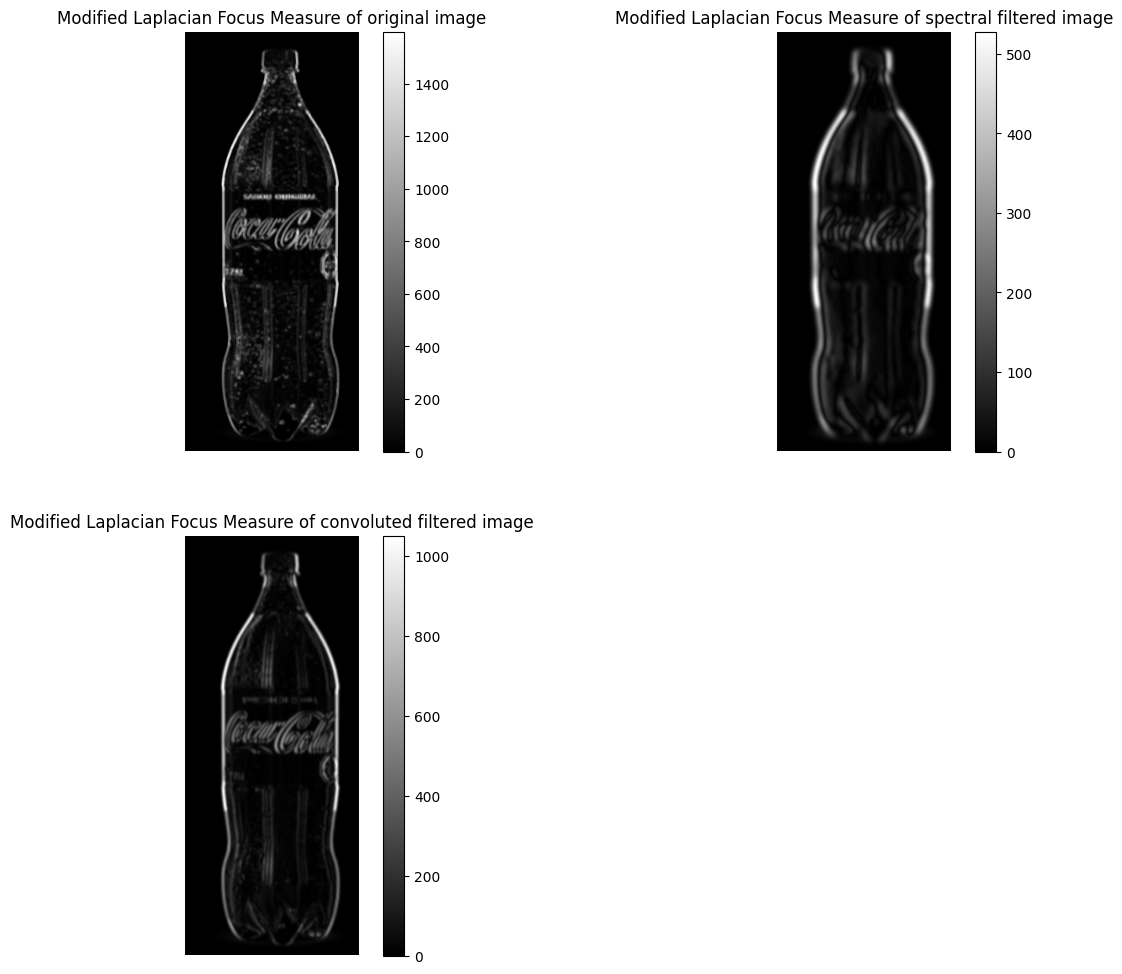

In [106]:
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.imshow(focus_measure_img, cmap='gray')
plt.title('Modified Laplacian Focus Measure of original image')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(focus_measure_fil, cmap='gray')
plt.title('Modified Laplacian Focus Measure of spectral filtered image')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(focus_measure_conv, cmap='gray')
plt.title('Modified Laplacian Focus Measure of convoluted filtered image')
plt.colorbar()
plt.axis('off')

plt.show()
